In [2]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import integrate
from scipy.optimize import minimize_scalar
from scipy.constants import k as kB, R, h, hbar
from scipy.optimize import curve_fit

In [3]:
with MPRester("OhzYzXS8KZ2GAhVz3g1zkqH8EJz32Y7X") as m:
    prim_struc = m.get_structure_by_material_id("mp-8188")
    ph_dos = m.get_phonon_dos_by_material_id("mp-8188")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Chaleur spécifique

## 1) Selon les données expérimentales

In [4]:
temp = np.arange(5,1000,5)
n_at = len(prim_struc)
R = 8.314
cv_real = np.array([ph_dos.cv(T) for T in temp])/(3*n_at*R)

## 2) Modèle d'Einstein

Dans le modèle d'Einstein, on suppose que chaque atome du cristal est un oscillateur harmonique qui vibre à une fréquence $\omega_E$.
On trouve donc la loi d'évolution de $C_v$ en fonction de la température suivante : $C_v(T) = 3R \left( \frac{\theta_E}{T} \right)^2 \frac{e^{\theta_E / T}}{(e^{\theta_E / T} - 1)^2}$, où $\theta_E$ est la température d'Einstein et est définie comme $\theta_E = \frac{\hbar \omega_E}{k_b}$

In [5]:
def CV_E(theta_E,T) : 
    cv = ((theta_E/temp)**2)*np.exp(theta_E/temp) / ((np.exp(theta_E/temp)-1)**2)
    return cv

def mse_E(theta_E):
    return np.sum((cv_real - CV_E(theta_E, temp)) ** 2)
    
    
opt_E = minimize_scalar(mse_E, bounds=(10, 1000), method="bounded")
print("La température d'Einstein minimisant l'erreur au sens des moindres carrés est :", opt_E.x, "[K]")

La température d'Einstein minimisant l'erreur au sens des moindres carrés est : 411.75860043195644 [K]


## 3) Modèle de Debye

Dans le modèle de Debye on suppose que toutes les fréquences ont la même dispersion linéaire $\omega_D = vq$ avec $v$ la vitesse de phase et $q$ le vecteur d'onde du phonon. On trouve donc la loi d'évolution de $C_v$ en fonction de la température suivante :$C_v(T) = 9NR \left( \frac{T}{\theta_D} \right)^3 \int_0^{\theta_D / T} \frac{x^4 e^x}{(e^x - 1)^2} \, dx$, où $\theta_D$ est la température de Debye et est définie comme $\theta_D = \frac{\hbar \omega_D}{k_b}$




In [6]:
def integrande(x):
    return (x**4*np.exp(x)) / (np.exp(x)-1)**2

def CV_D(theta_D, T) :
    cv = 3*(T/theta_D)**3 * integrate.quad(integrande,0,theta_D/T)[0]
    return cv

def mse_D(theta_D):
    return np.sum([(cv_real[i] - CV_D(theta_D, temp[i]))**2 for i in range(len(temp))])

opt_D = minimize_scalar(mse_D, bounds=(10,1000), method = "bounded")
print("La température de Debye minimisant l'erreur au sens des moindres carrés est :", opt_D.x, "[K]")

La température de Debye minimisant l'erreur au sens des moindres carrés est : 557.6214506926467 [K]


## Comparaison des différentes courbes de chaleur spécifique

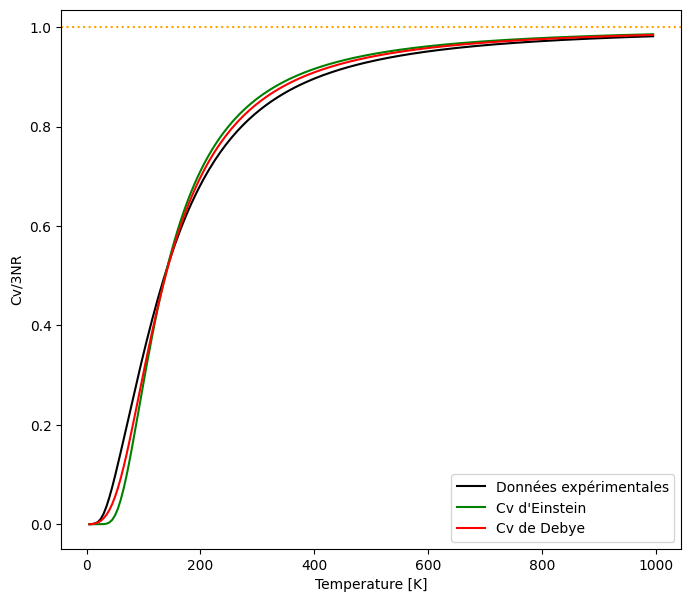

In [9]:
cv_E = CV_E(opt_E.x, temp)
cv_D = np.array([CV_D(opt_D.x, T) for T in temp])

plt.figure(figsize=(8, 7))
plt.plot(temp, cv_real, label="Données expérimentales", color='black')
plt.plot(temp, cv_E, label="Cv d'Einstein" , color='green')
plt.plot(temp, cv_D, label="Cv de Debye", color='red')
plt.axhline(y=1, color='orange', linestyle= 'dotted')
plt.xlabel('Temperature [K]')
plt.ylabel("Cv/3NR")
plt.legend()
plt.show()

On remarque donc que le modèle de Debye est plus proche des valeurs réelles que celui d'Einstein. On remarque également que les 2 modèles et les données expérimentales convergent tous vers la même valeur pour de grandes températures. 

# Densité d'état des phonons

In [23]:
hbar = 6.62607015e-34/(2*np.pi)
eV = 1.6022e-19 
A = 1e-10
toHz = 1e12 
toTHz = 1e-12 
k_B = 1.380649e-23  

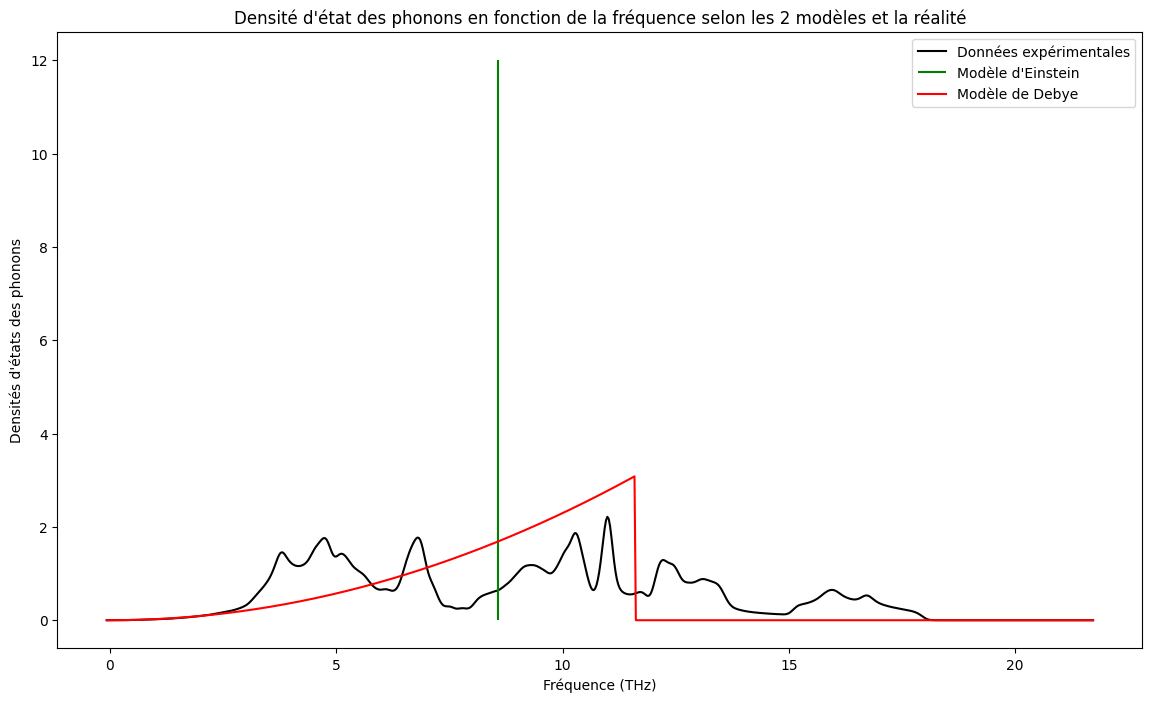

In [22]:
freq = ph_dos.frequencies 
dens = ph_dos.densities

w_E = toTHz * (opt_E.x * k_B)/hbar
w_D = toTHz * (opt_D.x * k_B)/hbar


dens_D = np.zeros(len(freq))
for i,f in enumerate(freq):
    w = 2*np.pi*f
    if w < w_D:
        dens_D[i] = (9*n_at*(w)**2/(w_D**3))

plt.figure(figsize=(14, 8))
plt.plot(freq, dens, color='black', label="Données expérimentales")
plt.vlines(w_E/(2*np.pi), 0, 3*n_at, colors='green', label="Modèle d'Einstein")
plt.plot(freq, dens_D*2*np.pi, color='red', label="Modèle de Debye")
plt.ylabel("Densités d'états des phonons")
plt.xlabel("Fréquence (THz)")
plt.title("Densité d'état des phonons en fonction de la fréquence selon les 2 modèles et la réalité")
plt.legend()
plt.show()